In [25]:
import numpy as np
import os
import random
import sys

sys.path.insert(0, '../src')
import utils, visualizations

In [32]:
def filter_images(data_dir,
                  visualize=False,
                  save_dir=None,
                  overwrite=False):
    if save_dir is not None:
        right_save_path = os.path.join(save_dir, "filtered_right_paths.txt")
        left_save_path = os.path.join(save_dir, "filtered_left_paths.txt")
        if os.path.exists(right_save_path) and os.path.exists(left_save_path) and not overwrite:
            utils.informal_log("File exists at {} and {} and not overwriting".format(
                left_save_path, right_save_path))
            return utils.read_file(left_save_path), utils.read_file(left_save_path)

    metadata_path = os.path.join(data_dir, "metadata.pkl")
    metadata = utils.read_file(metadata_path)

    # Map image names from Images/ to right/left names
    paired_image_names = metadata['image_list']
    single_image_names = sorted(os.listdir(os.path.join(data_dir, "right")))
    paired_single_dict = dict(zip(paired_image_names, single_image_names))

    # Get list of image names that are in "no_faces"
    filtered_boolean = metadata['no_faces']
    filtered_paired_image_names = np.array(paired_image_names)[filtered_boolean]
    # Get the corresponding right/left image names
    filtered_single_image_names = [paired_single_dict[paired_name] for paired_name in filtered_paired_image_names]
    assert len(filtered_paired_image_names) == len(filtered_single_image_names)
    if visualize:
        rand_int = random.randint(0, len(single_image_names) - 1)

        visualizations.show_image_rows(
            [[utils.read_file(os.path.join(data_dir, "Images", paired_image_names[rand_int])),
            utils.read_file(os.path.join(data_dir, "left", single_image_names[rand_int])),
            utils.read_file(os.path.join(data_dir, "right", single_image_names[rand_int]))]]
        )

    # Make separate lists for right and left
    left_save_paths = []
    right_save_paths = []
    for filename in filtered_single_image_names:
        left_save_paths.append(os.path.join(data_dir, "left", filename))
        right_save_paths.append(os.path.join(data_dir, "right", filename))
    if save_dir is not None:
        utils.write_file(left_save_paths, left_save_path, overwrite=overwrite)
        utils.write_file(right_save_paths, right_save_path, overwrite=overwrite)

    return left_save_paths, right_save_paths


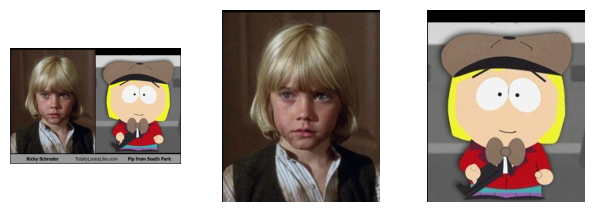

Saved file to ../data_local/tll/filtered_left_paths.txt
Saved file to ../data_local/tll/filtered_right_paths.txt


In [33]:
data_dir = "../data_local/tll/totally_looks_like"
save_dir = "../data_local/tll"

image_names = filter_images(
    data_dir=data_dir,
    visualize=True,
    save_dir=save_dir,
    overwrite=False)